In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('BID Historical Data.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.65 * len(df1))
test_size = int(0.25 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 3s 77ms/step - loss: 0.0349 - val_loss: 0.0603
Epoch 2/100
13/13 [==============================] - 0s 30ms/step - loss: 0.0078 - val_loss: 0.0185
Epoch 3/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0040 - val_loss: 0.0080
Epoch 4/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 5/100
13/13 [==============================] - 0s 32ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 6/100
13/13 [==============================] - 0s 29ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 7/100
13/13 [==============================] - 0s 29ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 8/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 9/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 10/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0017 - val_loss: 0.0035

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 6ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 682.4286833946874
Testing RMSE: 1053.8603574153246


In [14]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.013198254703732017
Testing MAPE: 0.020967179370073127


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=77
i=0
while(i<30):
    
    if(len(temp_input)>77):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.94456182 0.91530278 0.87680405 0.89374349 0.86448446 0.85370481
 0.84908496 0.89682339 0.91992263 0.90452314 0.90144324 0.93532213
 0.96920101 0.95842137 0.94302187 0.91530278 0.878344   0.93224223
 0.91530278 0.91684273 0.8875837  0.8875837  0.91068294 0.90452314
 0.89374349 0.90760304 0.90760304 0.91376284 0.91376284 0.91376284
 0.90452314 0.90760304 0.89220354 0.90760304 0.89682339 0.86756435
 0.85832466 0.85832466 0.8752641  0.85986461 0.87680405 0.86448446
 0.85832466 0.86448446 0.85216486 0.83676537 0.83214552 0.84908496
 0.84292516 0.83060557 0.83830532 0.82906562 0.86756435 0.87988395
 0.87680405 0.87680405 0.87680405 0.87372415 0.87680405 0.87064425
 0.86602441 0.85832466 0.85832466 0.84138522 0.83060557 0.83830532
 0.82752567 0.84292516 0.83984527 0.84600506 0.84292516 0.86756435
 0.86756435 0.87064425 0.85678471 0.83676537 0.82906562]
0 day output [[0.8113914]]
1 day input [0.91530278 0.87680405 0.89374349 0.86448446 0.85370481 0.84908496
 0.89682339 0.9199226

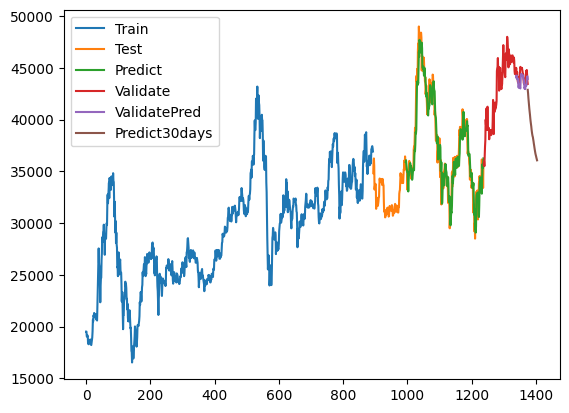

In [16]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [17]:
print(scaler.inverse_transform(lst_output))

[[42876.14323901]
 [42561.8848339 ]
 [42120.43986863]
 [41755.67067198]
 [41398.05233259]
 [41040.35658203]
 [40747.80427033]
 [40455.43000432]
 [40109.57042239]
 [39820.27712114]
 [39575.93648908]
 [39340.52910659]
 [39031.28113977]
 [38788.47711953]
 [38580.02624338]
 [38410.25966654]
 [38308.94005044]
 [38103.24114155]
 [37910.42538742]
 [37681.66956012]
 [37487.68876781]
 [37271.82964224]
 [37074.74853238]
 [36884.5454054 ]
 [36708.46788254]
 [36575.10391064]
 [36455.31398823]
 [36311.98332758]
 [36191.11351929]
 [36066.52410405]]
